In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from collections import defaultdict

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

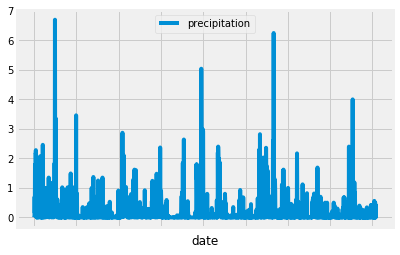

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
date_results = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date 1 year ago from the last data point in the database
last_year = date_results[0]
last_year_split = last_year.split("-")
last_year_split[0] = str(int(last_year_split[0])-1)
one_year_ago = "-".join(last_year_split)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).filter(Measurement.prcp != "None").all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns = ['date', 'precipitation'])
df.set_index('date', inplace=True, )

# Sort the dataframe by date
sorted_df = df.sort_values('date')
sorted_df.head()
# Use Pandas Plotting with Matplotlib to plot the data
sorted_df.plot()
plt.legend(loc='upper center')
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
num_station = session.query(func.count(Station.id)).all()
num_station

[(9)]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.tobs)).\
                               group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = active_station[0][0]
records = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                        filter(Measurement.station == most_active_station).all()
records

[(54.0, 85.0, 71.66378066378067)]

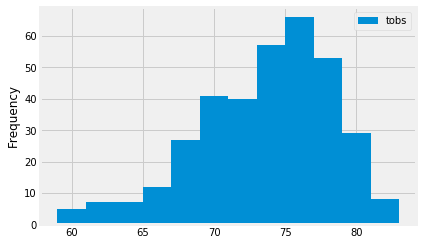

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = session.query(Measurement.tobs).filter(Measurement.station == most_active_station).filter(Measurement.date >= one_year_ago).all()
temp_list =[]
for temp in temp_results:
    temp_list.append(temp[0])
plt.hist(temp_list, bins=12, label='tobs')
plt.ylabel("Frequency")
plt.legend()
plt.show()
#plot with pandas
# temp_df = pd.DataFrame(temp_results, columns =['tobs'])
# temp_df.hist(bins=12)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start = '2015-04-02'
end = '2015-04-12'
previous_year= calc_temps(start, end)
print(previous_year)

[(63.0, 72.92753623188406, 80.0)]


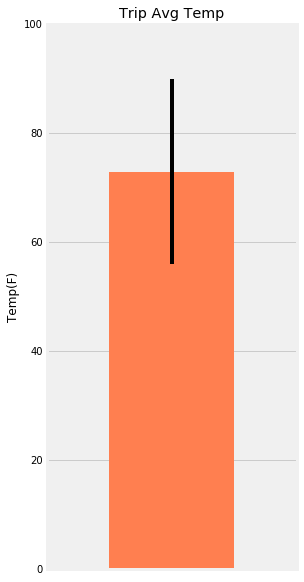

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avg_df = pd.DataFrame(previous_year, columns=['min','avg','max'])
error = avg_df['max']-avg_df['min']
 
avg_df['avg'].plot(kind ='bar',yerr=error, figsize=(4,8), color = 'coral')
plt.tight_layout()
plt.yticks(range(0,101,20))
plt.xticks([])#to get rid of line on error bar
plt.title('Trip Avg Temp')
plt.ylabel('Temp(F)')

plt.show()

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_results = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
                   filter(Measurement.date>=start).filter(Measurement.date<=end).\
                   filter(Measurement.prcp != "None").filter(Measurement.station == Station.station).\
                   order_by(func.sum(Measurement.prcp).desc()).group_by(Measurement.station).all()
rainfall_results

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
date_range = session.query(Measurement.date).filter(Measurement.date >= '2017-01-01').filter(Measurement.date <= '2017-01-07').group_by(Measurement.date).all()

# Use the start and end date to create a range of dates
convert_list =[]
adjust_dates = []
for i in range(len(date_range)):
    convert_list.append(date_range[i][0])
    adjust_dates.append(convert_list[i].replace('2017','2018'))
    
# Stip off the year and save a list of %m-%d strings
dates =[]
for i in range(len(convert_list)):
    split_list = convert_list[i].split('2017-')
    dates.append(split_list.pop())
    
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in dates:
    normals.append(daily_normals(date))

#unpack list of list    
adjust_normals =[]
for i in range(len(normals)):
    adjust_normals.append(normals[i][0])
adjust_normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_df = pd.DataFrame(adjust_normals, columns = ['tmin','tavg','tmax'])
daily_df['date'] = adjust_dates
daily_df.set_index('date',inplace=True)
daily_df.head()

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


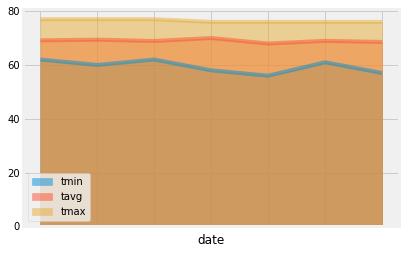

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
daily_df.plot.area(stacked=False)
plt.yticks(range(0,90,20))
plt.show()